# On-policy Entropy Regularized RL

In [10]:
import os

import mujoco_py
import gym
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy

from apmd_on.apmd import SAC

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
class EvaluateCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0, eval_env=None, model=None):
        super(EvaluateCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseRLModel
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # type: logger.Logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        self.eval_env = eval_env
        self.model = model
        self.means = []
        self.stds = []
        self.iter = 0

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        mean_reward, std_reward = evaluate_policy(self.model, self.eval_env, n_eval_episodes=5, deterministic=False)
        print(f"Iter {self.iter:d} mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
        self.means.append(mean_reward)
        self.stds.append(std_reward)
        self.iter += 1

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

# Learning rate schedule 
from typing import Callable
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

def plot_costs(rewards, names, smoothing_window=10, n=3, fig_name="acrobot.png", stds=None):
    fig = plt.figure(figsize=(7, 5))
    colors = ['tomato', 'royalblue', 'mediumpurple']
    for i in range(n):
        extend = np.concatenate([np.ones(smoothing_window)*rewards[i][0], rewards[i]])
        rewards_smoothed = pd.Series(extend).rolling(smoothing_window, min_periods=smoothing_window).mean().to_numpy()
        rewards_smoothed = rewards_smoothed[smoothing_window-1:]
        rewards_smoothed = rewards_smoothed[:5000]
        x = np.linspace(1, 5000, num=5000)
        if stds is None:
            plt.plot(rewards_smoothed, label=names[i], linewidth=3)
        else:
            lower = rewards_smoothed - stds[i][ :5000]
            upper = rewards_smoothed + stds[i][ :5000]
            plt.plot(rewards_smoothed, label=names[i], linewidth=3, c=colors[i])
            plt.fill_between(x, y1=lower, y2=upper, interpolate=True, c=colors[i], alpha=0.5)
    plt.xlabel("Episode")
    plt.ylabel("Episodic Costs")
    plt.title(fig_name)
    plt.legend()
    plt.show()
    # plt.close()
    # plt.savefig(fig_name)

Using cpu device
Eval num_timesteps=1000, episode_reward=-2.25 +/- 1.28
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -2.25    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-3.20 +/- 0.87
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -3.2     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
Eval num_timesteps=3000, episode_reward=-0.60 +/- 0.28
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -0.598   |
| time/              |          |
|    total_timesteps | 3000     |
| train/         

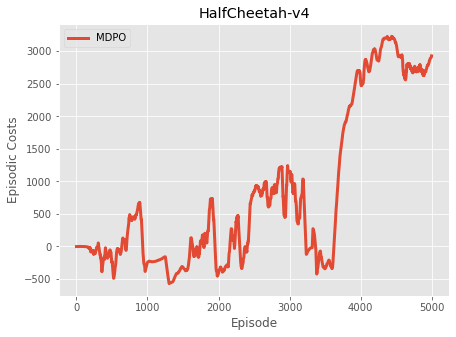

In [19]:
env_id = 'HalfCheetah-v4'
env = make_vec_env(env_id, n_envs=1)
env = VecNormalize(env)
eval_env = make_vec_env(env_id, n_envs=1)
eval_env = VecNormalize(eval_env)

mdpo_model = SAC("MlpPolicy",
                  env,
                  buffer_size=2048,
                  train_freq=2048,
                  verbose=1,
                  learning_rate=linear_schedule(5e-3))

eval_callback = EvalCallback(eval_env, best_model_save_path='logs/{}-mdpo/'.format(env_id),
                             log_path='logs/{}-mdpo/'.format(env_id), eval_freq=1000,
                             deterministic=True, render=False)
mdpo_model.learn(total_timesteps=5e6, callback=eval_callback)

results = np.array(eval_callback.evaluations_results)
mdpo_mean_reward = np.mean(results, axis=1)
mdpo_std_reward = np.std(results, axis=1)
np.save("{}-mdpo-mean-redundent.npy".format(env_id), mdpo_mean_reward)
np.save("{}-mdpo-std-redundent.npy".format(env_id), mdpo_std_reward)

plot_costs([mdpo_mean_reward], names=['MDPO'], smoothing_window=50, n=1, fig_name=env_id)